In [1]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

--2025-02-22 19:59:04--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  39.0MB/s    in 13s     

2025-02-22 19:59:17 (34.0 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



['--2025-02-22 19:59:17--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar',
 'Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152',
 'Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.',
 'HTTP request sent, awaiting response... 200 OK',
 'Length: 451020800 (430M) [application/x-tar]',
 'Saving to: ‘VOCtest_06-Nov-2007.tar’',
 '',
 '',
 'VOCtest_06-Nov-2007   0%[                    ]       0  --.-KB/s               ',
 'VOCtest_06-Nov-2007   0%[                    ]  93.03K   400KB/s               ',
 'VOCtest_06-Nov-2007   0%[                    ] 627.55K  1.32MB/s               ',
 'VOCtest_06-Nov-2007   0%[                    ]   3.02M  4.33MB/s               ',
 'VOCtest_06-Nov-2007   2%[                    ]   9.35M  10.1MB/s               ',
 'VOCtest_06-Nov-2007   3%[                    ]  15.98M  13.7MB/s               ',
 'VOCtest_06-Nov-2007   5%[>                   ]  22.61M  16.2MB/s          

In [2]:
!tar xvf VOCtrainval_06-Nov-2007.tar
#!tar xvf VOCtest_06-Nov-2007.tar

!rm VOCtrainval_06-Nov-2007.tar
#!rm VOCtest_06-Nov-2007.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/001732.jpg
VOCdevkit/VOC2007/JPEGImages/001733.jpg
VOCdevkit/VOC2007/JPEGImages/001734.jpg
VOCdevkit/VOC2007/JPEGImages/001738.jpg
VOCdevkit/VOC2007/JPEGImages/001739.jpg
VOCdevkit/VOC2007/JPEGImages/001741.jpg
VOCdevkit/VOC2007/JPEGImages/001746.jpg
VOCdevkit/VOC2007/JPEGImages/001747.jpg
VOCdevkit/VOC2007/JPEGImages/001749.jpg
VOCdevkit/VOC2007/JPEGImages/001750.jpg
VOCdevkit/VOC2007/JPEGImages/001752.jpg
VOCdevkit/VOC2007/JPEGImages/001754.jpg
VOCdevkit/VOC2007/JPEGImages/001755.jpg
VOCdevkit/VOC2007/JPEGImages/001756.jpg
VOCdevkit/VOC2007/JPEGImages/001758.jpg
VOCdevkit/VOC2007/JPEGImages/001759.jpg
VOCdevkit/VOC2007/JPEGImages/001761.jpg
VOCdevkit/VOC2007/JPEGImages/001765.jpg
VOCdevkit/VOC2007/JPEGImages/001766.jpg
VOCdevkit/VOC2007/JPEGImages/001768.jpg
VOCdevkit/VOC2007/JPEGImages/001771.jpg
VOCdevkit/VOC2007/JPEGImages/001772.jpg
VOCdevkit/VOC2007/JPEGImages/001775.jpg
VOCdevkit/VOC2007/JPEGImages/

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import  xml.etree.ElementTree as ET
import cv2
import shutil
import torch
import os
from torch.utils.data import TensorDataset, DataLoader

In [4]:
train_images="/content/VOCdevkit/VOC2007/JPEGImages/"
train_maps="/content/VOCdevkit/VOC2007/Annotations/"

classes=['aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor']

N_CLASSES=len(classes)
H,W=224,224
SPLIT_SIZE=int(H/32)
BATCH_SIZE=32

In [5]:
def extract_boxes_and_labels(annotation_path):
    """
    Extract bounding boxes and class labels from an XML file.

    Args:
    - annotation_path (str): Path to the XML annotation file.

    Returns:
    - boxes (list of lists): Bounding boxes as [xmin, ymin, xmax, ymax].
    - labels (list of str): Corresponding class labels for each box.
    """
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall('object'):
        label = obj.find('name').text
        if label in classes:
            labels.append(label)

            # Extract bounding box coordinates
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])

    return boxes, labels


In [6]:
def preprocess_xml(filename):

    tree = ET.parse(filename)
    root = tree.getroot()

    size_tree = root.find('size')
    height = float(size_tree.find('height').text)
    width = float(size_tree.find('width').text)


    bounding_boxes = []


    class_dict = {classes[i]: i for i in range(len(classes))}


    for object_tree in root.findall('object'):

        for bounding_box in object_tree.iter('bndbox'):
            xmin = float(bounding_box.find('xmin').text)
            xmax = float(bounding_box.find('xmax').text)
            ymin = float(bounding_box.find('ymin').text)
            ymax = float(bounding_box.find('ymax').text)
            break


        class_name = object_tree.find('name').text


        bounding_box = [
            (xmin + xmax) / (2 * width),
            (ymin + ymax) / (2 * height),
            (xmax - xmin) / width,
            (ymax - ymin) / height,
            class_dict[class_name]
        ]
        bounding_boxes.append(bounding_box)

    return torch.tensor(bounding_boxes)

In [10]:
example_annotation = train_maps + '000005.xml'
boxes, labels = extract_boxes_and_labels(example_annotation)
print("Boxes:", boxes)
print("Labels:", labels)


Boxes: [[263, 211, 324, 339], [165, 264, 253, 372], [5, 244, 67, 374], [241, 194, 295, 299], [277, 186, 312, 220]]
Labels: ['chair', 'chair', 'chair', 'chair', 'chair']


In [11]:
def initialize_yolo_output(boxes, labels):
    """
    Initialize the YOLO output tensor for a single image.

    Args:
    - boxes (list of lists): Bounding boxes as [xmin, ymin, xmax, ymax]
    - labels (list of str): Corresponding class labels for each box

    Returns:
    - output (numpy array): YOLO output tensor of shape (SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5)
    """
    # Initialize output tensor
    output = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        center_x = (xmin + xmax) / 2 / W
        center_y = (ymin + ymax) / 2 / H
        box_width = (xmax - xmin) / W
        box_height = (ymax - ymin) / H

        grid_x = int(center_x * SPLIT_SIZE)
        grid_y = int(center_y * SPLIT_SIZE)

        grid_x = min(grid_x, SPLIT_SIZE - 1)
        grid_y = min(grid_y, SPLIT_SIZE - 1)

        class_index = classes.index(label)
        one_hot_label = np.zeros(N_CLASSES)
        one_hot_label[class_index] = 1

        output[grid_y, grid_x, 0] = 1  # Objectness score
        output[grid_y, grid_x, 1:5] = [center_x, center_y, box_width, box_height]  # Box coordinates
        output[grid_y, grid_x, 5:] = one_hot_label  # Class labels

    return output


In [14]:
example_annotation = train_maps + '000005.xml'
boxes, labels = extract_boxes_and_labels(example_annotation)
yolo_output = initialize_yolo_output(boxes, labels)
print("YOLO Output Shape:", yolo_output.shape)


YOLO Output Shape: (7, 7, 25)


[![22.png](https://i.postimg.cc/4Nhq6cv8/22.png)](https://postimg.cc/jLtMKLFN)

[![23.png](https://i.postimg.cc/T1ZRkXHB/23.png)](https://postimg.cc/FkV5Rwvx)

In [12]:
def generate_output(bounding_boxes):
    # Initialize output label tensor
    output_label = np.zeros((SPLIT_SIZE, SPLIT_SIZE, N_CLASSES + 5))

    # Iterate through bounding boxes
    for b in range(len(bounding_boxes)):
        # Calculate grid positions
        grid_x = bounding_boxes[..., b, 0] * SPLIT_SIZE
        grid_y = bounding_boxes[..., b, 1] * SPLIT_SIZE

        # Convert to integer grid indices
        i = int(grid_x)
        j = int(grid_y)

        # Assign values to output label tensor
        output_label[i, j, 0:5] = [1., grid_x % 1, grid_y % 1, bounding_boxes[..., b, 2], bounding_boxes[..., b, 3]]
        output_label[i, j, 5 + int(bounding_boxes[..., b, 4])] = 1.

    # Convert output label tensor to TensorFlow tensor
    return torch.tensor(output_label)

In [13]:
im_paths=[]
xml_paths=[]

for i in os.listdir(train_maps)[:5000]:
    im_paths.append(train_images+i[:-3]+'jpg')
    xml_paths.append(train_maps+i)

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
])

images = []
for im_path in im_paths:
    # Open image using PIL
    img = Image.open(im_path).convert('RGB')

    # Apply transformations
    img_tensor = transform(img)

    images.append(img_tensor)

# Stack tensors
images = torch.stack(images)

In [ ]:
boxes = []

for xml_path in xml_paths:

    boxes.append(generate_output(preprocess_xml(xml_path)))

boxes_tensor = torch.stack(boxes, dim=0)

In [ ]:
type(boxes_tensor)

torch.Tensor

In [ ]:
import torch.nn as nn
import torchvision.models as models

NUM_FILTERS = 512
OUTPUT_DIM = int(N_CLASSES + 5)

# Load pre-trained ResNet50
base_model = models.resnet50(pretrained=True)

# Remove the last fully connected layer
base_model = nn.Sequential(*list(base_model.children())[:-2])

# Freeze the base model
for param in base_model.parameters():
    param.requires_grad = False


# Define additional layers
conv_layers = nn.Sequential(
    nn.Conv2d(2048, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),

    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1),

    nn.Conv2d(NUM_FILTERS, NUM_FILTERS, kernel_size=3, padding=1),
    nn.BatchNorm2d(NUM_FILTERS),
    nn.LeakyReLU(0.1)
)

flatten = nn.Flatten()

dense_layers = nn.Sequential(
    nn.Linear(NUM_FILTERS * (H // 32) * (W // 32), NUM_FILTERS),
    nn.BatchNorm1d(NUM_FILTERS),
    nn.LeakyReLU(0.1),

    nn.Linear(NUM_FILTERS, int(SPLIT_SIZE * SPLIT_SIZE * OUTPUT_DIM)),
    nn.Sigmoid()
)

# Combine all layers into a single sequential model
model = nn.Sequential(
    base_model,
    conv_layers,
    flatten,
    dense_layers,
    nn.Unflatten(1, (SPLIT_SIZE, SPLIT_SIZE, OUTPUT_DIM))
)

# Print model summary
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.5MB/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

[![24.png](https://i.postimg.cc/zGRVnx3y/24.png)](https://postimg.cc/w1gqzcXz)

In [ ]:
def difference(x, y):
    return torch.sum((y - x)**2)

def yolo_loss(y_true, y_pred):
    target = y_true[..., 0]  # Grid cell where we have information of object presence

    #--------------------------------------- for object

    target_indices = target == 1
    y_pred_extract = y_pred[target_indices]
    y_target_extract = y_true[target_indices]

    object_loss = difference(y_pred_extract[..., 0].float(), torch.ones_like(y_pred_extract[..., 0]).float())

    #------------------------------------------------------ for no object

    target_indices_no_obj = target == 0
    y_pred_extract_no_obj = y_pred[target_indices_no_obj]
    y_target_extract_no_obj = y_true[target_indices_no_obj]

    no_obj_loss = difference(y_pred_extract_no_obj[..., 0].float(), torch.zeros_like(y_pred_extract_no_obj[..., 0]).float())

    #-------------------------------------------------------- for object class loss

    y_pred_extract_class = y_pred[target_indices][:, 5:]
    class_extract = y_true[target_indices][:, 5:]

    class_loss = difference(y_pred_extract_class.float(), class_extract.float())

    #--------------------------------------------------------- for object center loss

    y_pred_extract_center = y_pred[target_indices][:, 1:3]
    center_target = y_true[target_indices][:, 1:3]

    center_loss = difference(y_pred_extract_center.float(), center_target.float())

    #------------------------------------------------------- for width and height

    size_pred = y_pred[target_indices][:, 3:5]
    size_target = y_true[target_indices][:, 3:5]

    size_loss = difference(torch.sqrt(torch.abs(size_pred.float())), torch.sqrt(torch.abs(size_target.float())))

    box_loss = center_loss + size_loss

    lambda_coord = 5
    lambda_no_obj = 0.5

    loss = object_loss + (lambda_no_obj * no_obj_loss) + lambda_coord * box_loss + class_loss

    return loss

In [ ]:
# Move model and data to MPS device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
boxes = torch.stack(boxes, dim=0)  # stacks the list into a tensor of shape (N, 7, 7, 25)
boxes = boxes.to(device)
images = images.to(device)



# Define your loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Assuming batch size of 32 and iterating through batches
    batch_size = 32
    for i in range(0, len(images), batch_size):
        img_batch = images[i:i+batch_size]
        target_batch = boxes[i:i+batch_size]

        # Forward pass
        outputs = model(img_batch)

        # Assuming you have a custom YOLO-like loss function
        loss = yolo_loss(target_batch,outputs)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (len(images) / batch_size)}')

print('Finished Training')

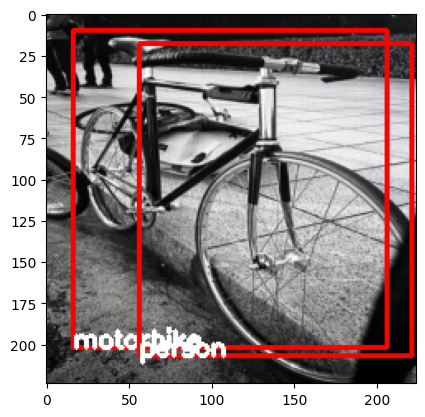

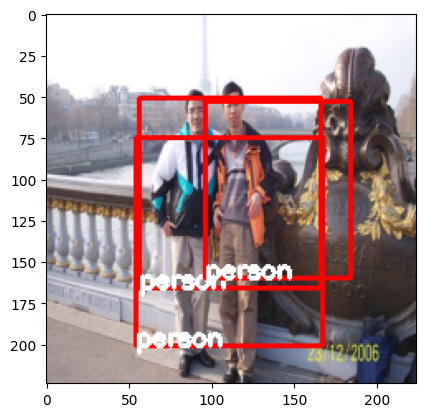

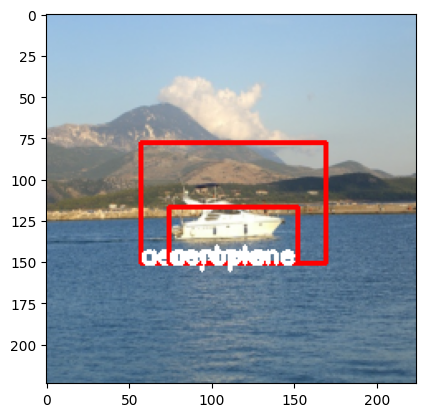

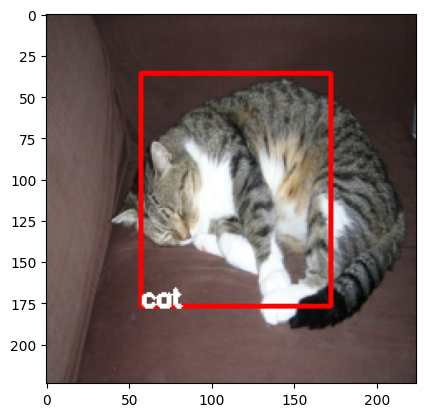

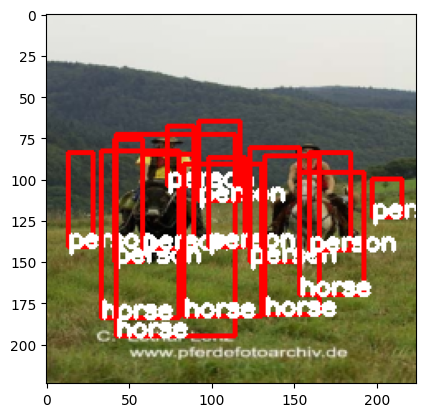

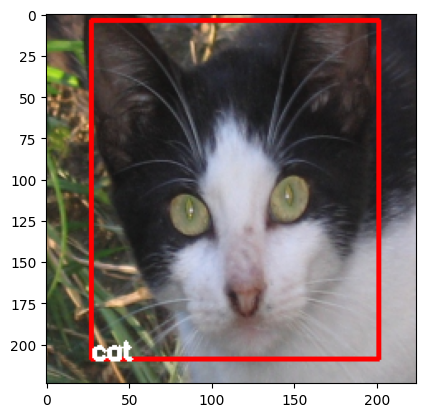

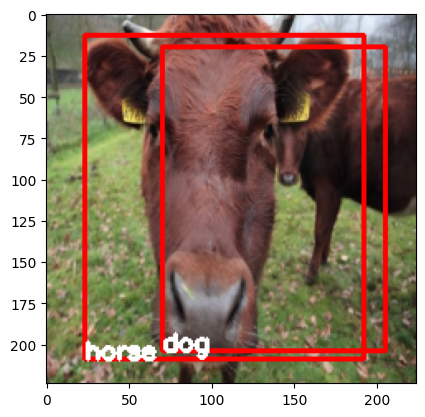

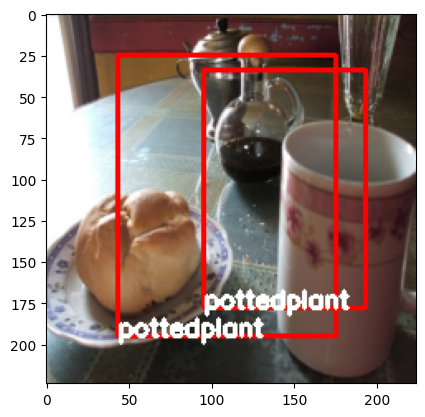

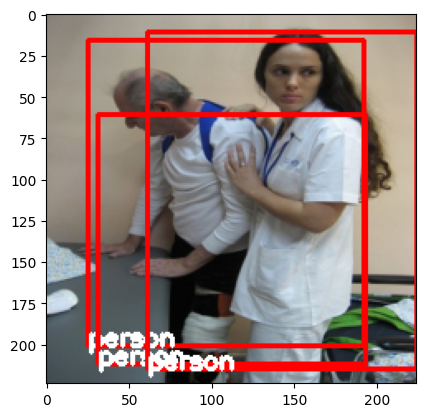

In [ ]:
for j in [60,10,5,4,3416,500,600,800,560]:

    output = model(images[j:j+32])[:1] #SINCE MODEL TAKES 32 AS BATCH AND NOT SINGLE IMAGE

    # Threshold for detection
    THRESH = 0.25

    # Get object positions
    object_positions = torch.where(output[..., 0] >= THRESH)
    selected_output = output[object_positions]

    # Initialize lists for final boxes and scores
    final_boxes = []
    final_scores = []

    # Iterate through object positions
    for i in range(len(object_positions[0])):
        if selected_output[i][0] > THRESH:
            # Extract box parameters
            output_box = selected_output[i][1:5].float()
            x_centre = (object_positions[1][i] + output_box[0]) * 32
            y_centre = (object_positions[2][i] + output_box[1]) * 32
            x_width, y_height = torch.abs(224 * output_box[2]), torch.abs(224 * output_box[3])
            x_min, y_min = int(x_centre - (x_width / 2)), int(y_centre - (y_height / 2))
            x_max, y_max = int(x_centre + (x_width / 2)), int(y_centre + (y_height / 2))

            # Adjust bounding box coordinates
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(224, x_max)
            y_max = min(224, y_max)

            # Append to final boxes
            final_boxes.append([x_min, y_min, x_max, y_max,
                               classes[torch.argmax(selected_output[i][5:]).item()]])
            final_scores.append(selected_output[i][0].item())


    img = np.array(images[j].permute(1, 2, 0).to('cpu')).copy()

    for i in range(len(final_boxes)):

        # Extract object classes and boxes
        object_classes = final_boxes[i][4]
        nms_output = final_boxes[i][0:4]

        x1, y1 = nms_output[:2]
        x2, y2 = nms_output[2:]

        # Specify the color (in BGR format) and thickness
        color = (255, 0, 0)
        thickness = 2

        # Draw the rectangle
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)

        # Add text (object classes)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        text_position = (x1, y2)

        cv2.putText(img, object_classes, text_position, font, font_scale, font_color, thickness)
    plt.imshow(img)
    plt.show()

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class SSD(nn.Module):
    def __init__(self, num_classes):
        super(SSD, self).__init__()

        # Load pretrained ResNet-50 and remove the fully connected layer
        resnet = models.resnet50(pretrained=True)
        self.base = nn.Sequential(*list(resnet.children())[:-2])  # Excluding avgpool and fc layer

        # Extra layers for feature maps
        self.extra_layers = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(1024, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Default box settings
        self.num_boxes = [4, 6, 6, 6, 4]  # Number of default boxes per feature map cell

        # Localization heads
        self.loc_layers = nn.ModuleList([
            nn.Conv2d(1024, self.num_boxes[0] * 4, kernel_size=3, padding=1),
            nn.Conv2d(1024, self.num_boxes[1] * 4, kernel_size=3, padding=1),
            nn.Conv2d(512, self.num_boxes[2] * 4, kernel_size=3, padding=1),
            nn.Conv2d(256, self.num_boxes[3] * 4, kernel_size=3, padding=1),
        ])

        # Classification heads
        self.cls_layers = nn.ModuleList([
            nn.Conv2d(1024, self.num_boxes[0] * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(1024, self.num_boxes[1] * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(512, self.num_boxes[2] * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, self.num_boxes[3] * num_classes, kernel_size=3, padding=1),
        ])

    def forward(self, x):
        locs, confs = [], []

        # Base network
        x = self.base(x)

        # Extra layers
        for i, layer in enumerate(self.extra_layers):
            x = layer(x)
            if i % 2 != 0:
                loc = self.loc_layers.pop(0)(x)
                conf = self.cls_layers.pop(0)(x)

                # Reshape outputs
                loc = loc.permute(0, 2, 3, 1).contiguous()
                loc = loc.view(loc.size(0), -1, 4)
                locs.append(loc)

                conf = conf.permute(0, 2, 3, 1).contiguous()
                conf = conf.view(conf.size(0), -1, num_classes)
                confs.append(conf)

        # Concatenate results
        locs = torch.cat(locs, dim=1)
        confs = torch.cat(confs, dim=1)

        return locs, confs


In [17]:
class SSDLoss(nn.Module):
    def __init__(self, num_classes):
        super(SSDLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth_l1 = nn.SmoothL1Loss()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, loc_preds, loc_targets, conf_preds, conf_targets):
        # Localization loss (Smooth L1)
        loc_loss = self.smooth_l1(loc_preds, loc_targets)

        # Confidence loss (Cross Entropy)
        conf_loss = self.cross_entropy(conf_preds.view(-1, self.num_classes), conf_targets.view(-1))

        # Total loss
        return loc_loss + conf_loss


In [22]:
num_classes = N_CLASSES + 1  # Including background class
model = SSD(num_classes).to(device)
criterion = SSDLoss(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for i in range(0, len(images), BATCH_SIZE):
        img_batch = images[i:i+BATCH_SIZE]
        target_batch = boxes_tensor[i:i+BATCH_SIZE]

        # Forward pass
        loc_preds, conf_preds = model(img_batch)

        # Calculate loss
        loss = criterion(loc_preds, target_batch[..., :4], conf_preds, target_batch[..., 4])

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / (len(images) / BATCH_SIZE)}')
